In [2]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
from pyscf.scf.hf import dump_scf_summary
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py


In [3]:
# H2 molecule
def run_scf(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.;H 0. 0. 1.;", basis=f'ccecpccpvdz', unit='bohr')
    mf = scf.UHF(mol)
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm)
    dump_scf(mf.mol, 'scf.hdf5', mf.energy_tot(), mf.mo_energy, mf.mo_coeff, mf.mo_occ)
    return mf

def run_lda_be(scf_checkfile):
    print("Be atom neutral LDA spin=2")
    mol = gto.M(atom="Be 0. 0. 0.", spin=2,basis=f'ccpvdz', unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")        
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_li(scf_checkfile):
    print("Li atom neutral LDA spin=1")
    mol = gto.M(atom="Li 0. 0. 0.",basis=f'ccpvtz', spin=1, unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_he(scf_checkfile):
    print("He atom neutral LDA spin=0")
    # mol = gto.M(atom="He 0. 0. 0.", basis="ccECP_cc-pVDZ", ecp="ccecp", unit='bohr')
    mol = gto.M(atom="He 0. 0. 0.", basis="ccpvdz", unit='bohr')    
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_h2(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 2", spin = 2, basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.xc='LDA, VWN'
    mf.kernel()    
    # mf.kernel(dm, xc='LDA,VWN')
    return mf

def run_lda(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.", spin=1,basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf
    
def run_casscf(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    mc = mcscf.CASSCF(mf,2,2)
    mc.chkfile = ci_checkfile
    mc.kernel()
    with h5py.File(mc.chkfile, "a") as f:
        print("Available output from CASSCF:", f["mcscf"].keys())
        f["mcscf/nelecas"] = list(mc.nelecas)
        f["mcscf/ci"] = mc.ci
    return mc

def run_casci(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    # ncas: orbitals
    # nelecas: electrons
    ncas = 4
    nelecas = 2
    mc = mcscf.CASCI(mf, ncas, nelecas)
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff
        print("Available output from CASCI:", f["ci"].keys())
    return mc

def make_wf_object(scf_checkfile, ci_checkfile):
    mol, mf, mc = pyq.recover_pyscf(scf_checkfile, ci_checkfile=ci_checkfile)
    wf, _ = pyq.generate_wf(mol, mf, mc=mc)
    return wf

def stat_qmc(etot, filename):
    block_sizes = np.linspace(2,len(etot[discard:])//16, 10, dtype=int)
    reblocks = [len(etot)//s for s in block_sizes]

    plt.figure()
    df = pd.DataFrame([pyq.read_mc_output(filename, warmup=discard, reblock=reblock) for reblock in reblocks])
    df['block_size'] = block_sizes
    plt.plot("block_size",'energytotal_err',data=df, marker='o')
    plt.xlabel("Block size")
    plt.ylabel("Estimated uncertainty (Ha)")

def reblock(e, discard, reblock_size):
    e = e[discard:]
    vals = pyqmc.reblock.reblock(e,int(len(e)/reblock_size))
    # import pdb
    # pdb.set_trace()
    
    e_m  = np.mean(vals, axis=0)
    e_d  = scipy.stats.sem(vals, axis=0)    
    return e, e_m, e_d

scf_checkfile = "scf.hdf5"
ci_checkfile = "ci.hdf5"
# mf = run_scf(scf_checkfile)
mf_lda = run_lda_he(scf_checkfile)

# mc = run_casci(scf_checkfile, ci_checkfile)

He atom neutral LDA spin=0
HF
converged SCF energy = -2.85516047724274  <S^2> = 0  2S+1 = 1
LDA
converged SCF energy = -2.82670655418611  <S^2> = 4.4408921e-16  2S+1 = 1


In [4]:
from recipes import ABOPTIMIZE, OPTIMIZE
import importlib, recipes, linemin, wftools
modules = [recipes, linemin, wftools]
for m in modules:
    importlib.reload(m)

    # Jastrow optimizationn
    
for fname in ['sj.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
print("RUNNING VMC OPTIMIZATION")
# pyq.OPTIMIZE(scf_checkfile, "sj.hdf5", ci_checkfile=ci_checkfile, max_iterations=2, verbose=False)
recipes.OPTIMIZE(scf_checkfile, "sj.hdf5", max_iterations=4, nconfig=200, verbose=True)

# Jastrow optimization results
df = pyq.read_opt("sj.hdf5")
df

RUNNING VMC OPTIMIZATION
> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/recipes.py(242)initialize_qmc_objects()
    240         import pdb
    241         pdb.set_trace()
--> 242         acc = pyqmc.accumulators.gradient_generator(
    243             mol, wf, to_opt, nodal_cutoff=nodal_cutoff
    244         )



ipdb>  c


starting warmup
finished warmup
----------vmc done
descent en -2.740128053503458 0.037128758130599626  estimated sigma  5.250799330236432
descent |grad| 0.7445437996438785
----------vmc done
descent en -2.8863316079942836 0.008277274286534273  estimated sigma  1.1705833555498855
descent |grad| 0.08624588752857139
----------vmc done
descent en -2.872863055448378 0.009223887310533967  estimated sigma  1.3044546532358228
descent |grad| 0.09390393418077081
----------vmc done
descent en -2.8585237194129895 0.012085975978924147  estimated sigma  1.7092151143909975
descent |grad| 0.04973574275358379


,energy,iteration,error,fname
0,-2.740128,0,0.037129,sj.hdf5
1,-2.886332,1,0.008277,sj.hdf5
2,-2.872863,2,0.009224,sj.hdf5
3,-2.858524,3,0.012086,sj.hdf5


In [61]:
tstep = 0.1
nconfig = 200
nblocks = 1000
nsteps_per_block = 4
discard = 100

In [62]:
#PYQMC VMC with jastrow
#
#
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['vmc-j-001.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC, ABVMC, VMC
VMC("scf.hdf5", "vmc-j-001.hdf5",
    load_parameters="sj.hdf5", verbose=True,
    nblocks=nblocks, 
    nsteps_per_block=nsteps_per_block,
    tstep= tstep,
    nconfig=nconfig)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Mean  etot_j ,  -2.8919092744850654 +/- 0.002111619811798228
Mean  ee_j ,  0.9462157572845078 +/- 0.0019830863317500513
Mean  ei_j ,  -6.64906668203347 +/- 0.12090496675444168
Mean  ke_j ,  2.8109416502638966 +/- 0.11921966447813188


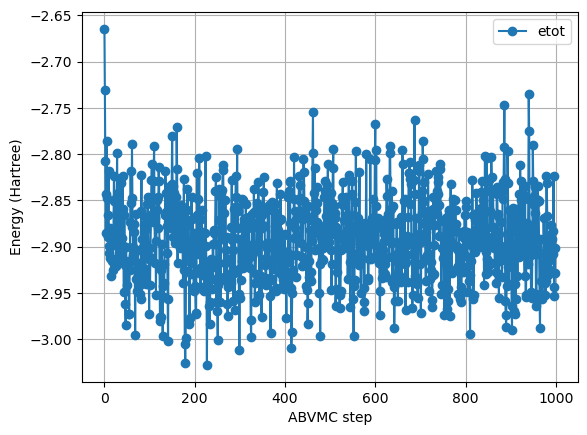

In [63]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

import matplotlib.pyplot as plt
with h5py.File("vmc-j-001.hdf5") as f:
    ee_j = f['energyee'][...]   
    ei_j = f['energyei'][...]
    # ii = f['energyii'][...]    
    ke_j = f['energyke'][...]
    etot_j = f['energytotal'][...]
plt.plot(etot_j, marker='o', label="etot")
# plt.plot(ee_j, marker='o', label="ee")
# plt.plot(ei_j, marker='o', label="ei")
# plt.plot(ke_j, marker='o', label="ke")

# plt.plot(vxc-vxc[0], marker='o', label="vxc")
plt.legend()
plt.xlabel("ABVMC step")
plt.ylabel("Energy (Hartree)")
# plt.xlim((200,500))
# plt.ylim((-10, 5))
plt.grid()
# plt.figure()
discard = 100
for e in [etot_j, ee_j, ei_j, ke_j]:
    e_m = np.mean(e[discard:])
    e_d = np.var(e[discard:])
    print("Mean ", namestr(e, globals())[0], ", ", e_m, "+/-", e_d)

# e_m = np.mean(etot[discard:])
# e_d = np.var(etot[discard:])
# # e_m2 = np.mean(etot2[discard:])
# # e_d2 = np.var(etot2[discard:])
# print("Mean VMC Energy, ", e_m, "+/-", e_d)
# print("LDA Energy, ", mf.energy_tot())
# plt.plot(ed, marker='o', label="ke")

# print('ee', np.mean(ee[discard:]))
# print('ei', np.mean(ei[discard:]))
# print('ke', np.mean(ke[discard:]))


In [64]:
#ABVMC with jastrows
#
#
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['abvmc-j-001.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC, ABVMC, VMC

ABVMC("scf.hdf5", "abvmc-j-001.hdf5", 
      load_parameters="sj.hdf5", verbose=True,  
      nblocks=nblocks, 
      nsteps_per_block=nsteps_per_block,
      tstep= tstep, 
      nconfig=nconfig)

Using spherical guess
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Mean  etot_j_abvmc ,  -2.9130422348652196 +/- 0.0149835262635887
LDA Energy,  -2.8267065541861145


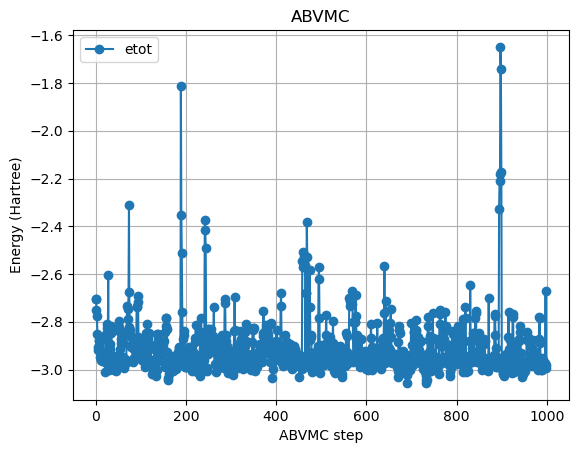

In [65]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
import matplotlib.pyplot as plt
with h5py.File("abvmc-j-001.hdf5") as f:
    ee_abvmc = f['energyee'][...]   
    ei_abvmc = f['energyei'][...]
    vh_abvmc = f['energyvh'][...]   
    vxc_abvmc = f['energyvxc'][...]       
    # eid = f['energyeid'][...]    
    ii_abvmc = f['energyii'][...]    
    ke_abvmc = f['energyke'][...]
    ka_abvmc = f['energyka'][...]
    kb_abvmc = f['energykb'][...]   
    ecorr_abvmc = f['energycorr'][...]    
    etot_j_abvmc = f['energytotal'][...] 
vhxc_abvmc = vh_abvmc + vxc_abvmc

plt.plot(etot_j_abvmc, marker='o', label="etot")

plt.legend()
plt.xlabel("ABVMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()
plt.title('ABVMC')
for e in [etot_j_abvmc]:
    e_m = np.mean(e[discard:])
    e_d = np.var(e[discard:])
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]
    print("Mean ", name, ", ", e_m, "+/-", e_d)
print("LDA Energy, ", mf_lda.energy_tot())



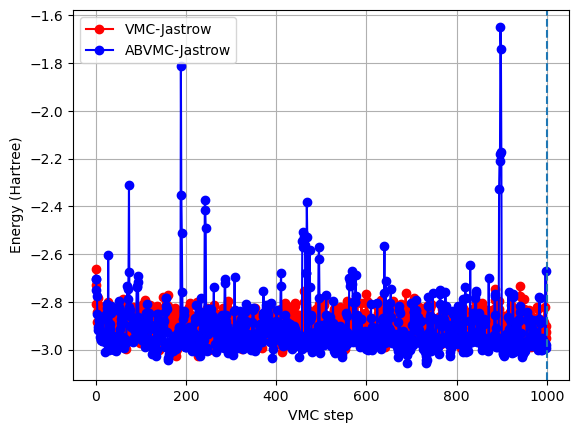

In [66]:
plt.plot(etot_j, marker='o', color = 'r', label="VMC-Jastrow")
plt.plot(etot_j_abvmc, marker='o', color='b', label="ABVMC-Jastrow")

plt.legend()
plt.xlabel("VMC step")
plt.ylabel("Energy (Hartree)")
# plt.ylim((-1.4, -1))
discard =  1000
plt.axvline(discard, linestyle='dashed')
plt.axhline(np.mean(etot_j[discard:]), color='r')
plt.axhline(np.mean(etot_j_abvmc[discard:]), color='b')
plt.grid()
